In [1]:
using Pkg 
pkg"activate ."
pkg"instantiate"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using LinearAlgebra, Test, SparseArrays, Plots, Parameters, OffsetArrays, DifferentialEquations, IterativeSolvers, LinearMaps
using Plots, BenchmarkTools, Perla1

# With K cohorts

## Setup (Modify these lines for different setups)

In [3]:
K = 2
N = 15
Δt_cohort = 5
Δθ = 0.2

0.2

## Setup for the corresponding `params`

In [4]:
# utils for Cartesian
import Base.sum
sum(I::CartesianIndex) = sum(Tuple(I))
subtract_by_one(I::CartesianIndex, i::Int64, length::Int64) = I - unit_vector(i, length)
add_by_one(I::CartesianIndex, i::Int64, length::Int64) = I + unit_vector(i, length)
function unit_vector(i::Int64, length::Int64)
   v = fill(0, length)
   v[i] = 1
   return CartesianIndex(Tuple(v))
end

# getting some params
ζ = 0.1 # forgetting rate
cohorts = tuple(fill(N, K)...)
ts_cohort = range(Δt_cohort, length = (K-1), step = Δt_cohort)
θs = range(Δθ, length = K, step = Δθ)
θ(t) = t < ts_cohort[1] ? θs[1] : θs[findall(t .>= ts_cohort)[end]] # return θ that corresponds to ts_cohort
T = ts_cohort[end] + Δt_cohort
params = (θ = θ, cohorts = cohorts, ts_cohort = ts_cohort, ζ = ζ)
f_0 = [1.0; fill(0.0, (N+1)^K-1)]
setsize = length(f_0)

# indices
indices = CartesianIndices(reshape(f_0, Tuple(fill(0:N, K))))
full_aware_counts = (i -> sum(Tuple(indices[i]) .== N)).(1:setsize) # number of cohorts that are fully awared
any_aware_counts = (i ->  sum(Tuple(indices[i]) .!= 0)).(1:setsize) # number of cohorts that aren't zero
i_pasts = [(indices[i] - unit_vector(j, length(indices[i]))) for i in 1:setsize, j in 1:K]
i_futures = [(indices[i] + unit_vector(j, length(indices[i]))) for i in 1:setsize, j in 1:K]
params = merge(params, (full_aware_counts = full_aware_counts, any_aware_counts = any_aware_counts,
                        i_pasts = i_pasts, i_futures = i_futures));

## Definte the corresponding operator and its properties

In [5]:
# solve the corresponding ODE
O! = get_transition_operator(params);

## Solve!

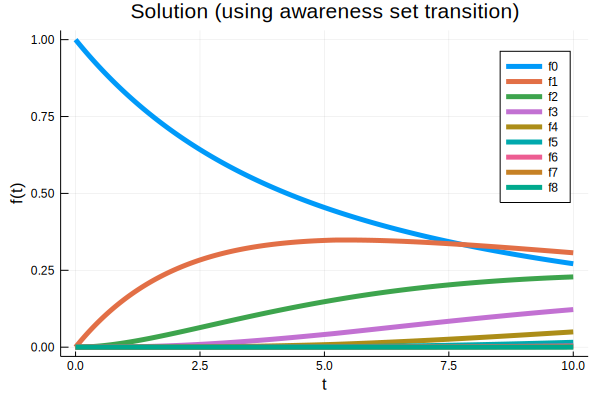

In [6]:
sol_awareness_matrix_free = solve_transition_dynamics(O!, params, f_0, T)
# enable the next line instead for benchmarking:
# sol_awareness_matrix_free = @btime solve_transition_dynamics($O!, $params, $f_0, $T)

# convert to the counting solution
setsize = length(f_0)
indices = CartesianIndices(reshape(1:setsize, Tuple(fill(0:N, K))))
counts = (x -> sum(indices[x])).(1:setsize) # index to count size

f0_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 0]) # no product
f1_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 1]) # 1 product
f2_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 2]) # 2 products
f3_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 3]) # 3 products
f4_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 4]) # 4 products
f5_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 5]) # 5 products
f6_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 6]) # 6 products
f7_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 7]) # 7 products
f8_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 8]) # 8 products

# plot
plot(0:0.01:T, [f0_awareness_matrix_free, f1_awareness_matrix_free, f2_awareness_matrix_free,
        f3_awareness_matrix_free, f4_awareness_matrix_free, f5_awareness_matrix_free,
        f6_awareness_matrix_free, f7_awareness_matrix_free, f8_awareness_matrix_free],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "f3" "f4" "f5" "f6" "f7" "f8"])

## Find stationary distribution
Note that the space size is $(N+1)^K$.

In [7]:
map_matfree! = LinearMap((y,x) -> transition_operator_base!(y, x, params, T), length(f_0); ismutating=true)
stationary, history = @time gmres!(fill(1/length(f_0), length(f_0)), map_matfree!, similar(f_0), log = true)
stationary /= sum(stationary) # normalize

  1.391961 seconds (5.90 M allocations: 667.828 MiB, 9.90% gc time)


256-element Array{Float64,1}:
 0.00023639670004828076
 0.00023639669782738387
 0.0003059459163997564 
 0.00044392688147099405
 0.000663163865120041  
 0.0009799147931563875 
 0.001405395144846424  
 0.001936729231449757  
 0.0025480507439739138 
 0.00318456886694172   
 0.0037633458114533706 
 0.004183581749831542  
 0.004345879608496769  
 ⋮                     
 0.004184836766390196  
 0.003255296108163738  
 0.002267167391806741  
 0.0014063335379131358 
 0.0007695664523238221 
 0.00036633937640311796
 0.0001487774050653514 
 5.015285952490767e-5  
 1.3478871309322974e-5 
 2.7086336344477594e-6 
 3.6191214259876556e-7 
 2.4133169185067497e-8 